
# Introduction
This assignment will center around semantic segmentation of the dataset in the TGS salt identification challenge. Several of the Earths accumulations of oil and gas **also** have huge deposits of salt, which is easier to detect than the actual hydrocarbons. However, knowing where the salt deposits are precisely is still quite difficult, and segmentation of the seismic images is still something that requires expert interpretation of the images. This leads variable, and highly subjective renderings. To create more accurate, objective segmentations TGS (the worlds leading geoscience data company) have created this challenge to determine if a deep learning model is up to the task.

## Dataset
In this assigmnet you will be given 3500 annotated images. The image, and mask dimensions are 128x128 pixels. With each image there follows an annotation mask where each pixel is classified as `1` (salt deposit) or `0` not salt deposit. The test-dataset contains 500 images, where no ground truth masks are given. To evualuate your model on the test dataset, submit your predictions to the Kaggle leaderboard.

## Assignment tasks

1. Implement a U-net model, and train it to segment the dataset.
2. Implement a U-net model that uses a pre-trained backbone model of your choice (VGGnet, ResNet, DarkNet, etc.), and train it to segment the dataset.
3. Train one of the models from part 1 or 2 on Orion, and compare the training times and attained performances.
4. Submit the best model prediction on Kaggle learderboard.


## Submissions to the Kaggle leaderboard

Link to the Kaggle leaderboard will be posted in the Canvas assignment.

```python
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False)        # Remember to store the dataframe to csv without the nameless index column.
```


# Library imports

In [ ]:
import time
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as ks
import tensorflow as tf

SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

from utilities import *
from visualization import *


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from tensorflow.keras.optimizers import Adam
from utilities import F1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mounted at /content/drive


# Data loading

Load the data from the HDF5 file `student_TGS_challenge.h5` that is available on Canvas, and Kaggle.
The data should be loaded in the same manner as in CA2.

In [ ]:
dataset_path = 'student_TGS_challenge.h5'

with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test  = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))



Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 3500
Nr. test images: 500


# Visualization

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant.

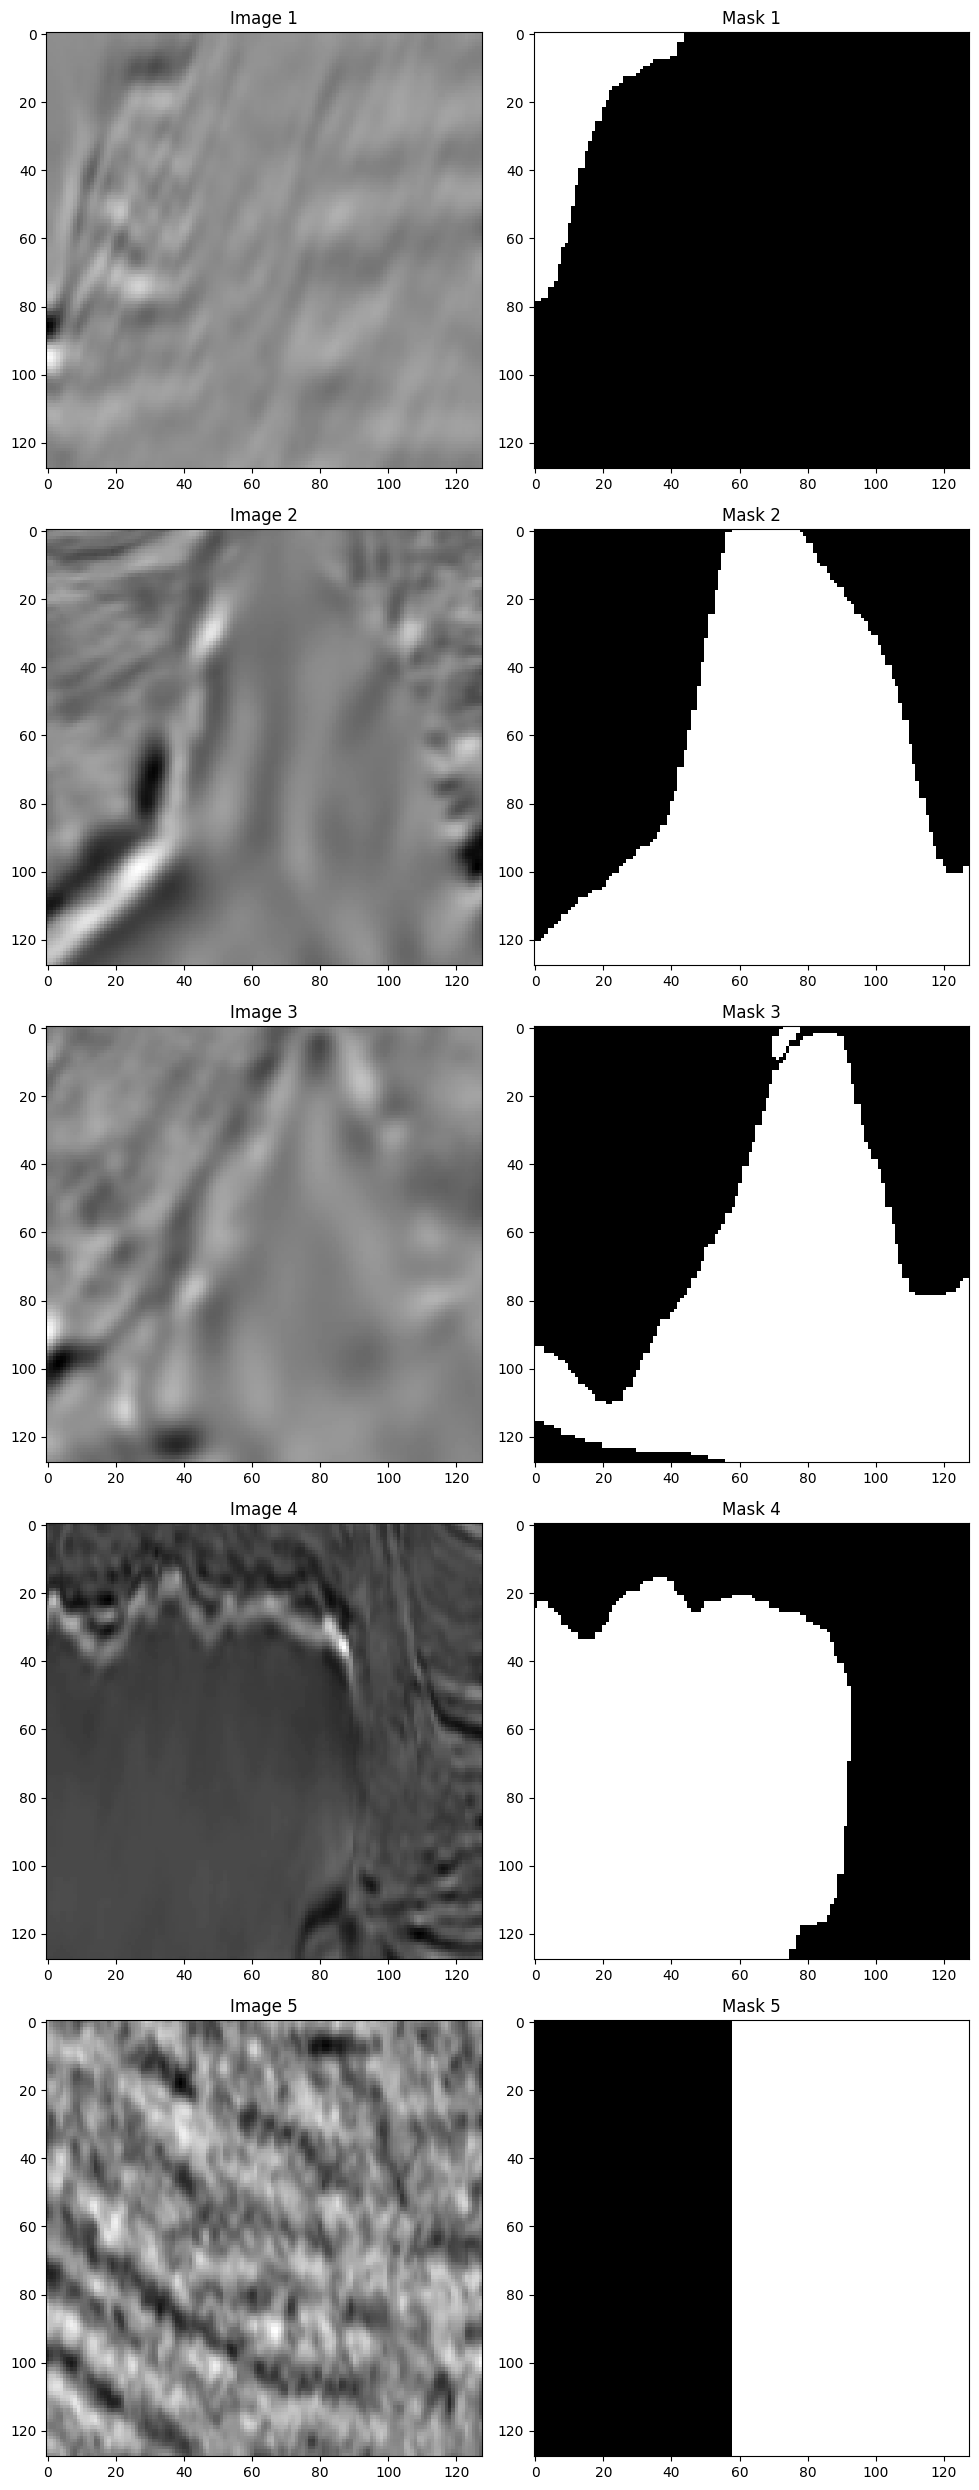

In [ ]:
# Visualization of the images and their corresponding masks
def plot_samples(images, masks=None, num_samples=5):

    fig, axes = plt.subplots(num_samples, 2 if masks is not None else 1, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = images[i]
        if len(img.shape) == 2:
            axes[i, 0].imshow(img, cmap='gray')
        else:
            axes[i, 0].imshow(img[..., 0], cmap='gray')

        axes[i, 0].set_title(f"Image {i+1}")

        if masks is not None:
            mask = masks[i]
            if len(mask.shape) == 2:
                axes[i, 1].imshow(mask, cmap='gray')
            else:
                axes[i, 1].imshow(mask[..., 0], cmap='gray')
            axes[i, 1].set_title(f"Mask {i+1}")

    plt.tight_layout()
    plt.show()


plot_samples(X_train, y_train)



# Preprocessing

Preprocess the dataset in whatever ways you think are helpful.

In [ ]:
# Normalization of our data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [ ]:
# Check distrubution of pixels
salt_pixels = np.sum(y_train)
total_pixels = y_train.shape[0] * y_train.shape[1] * y_train.shape[2]
no_salt_pixels = total_pixels - salt_pixels

print(f"Salt pixels: {salt_pixels}, No Salt pixels: {no_salt_pixels}")


Salt pixels: 14458940, No Salt pixels: 42885060.0


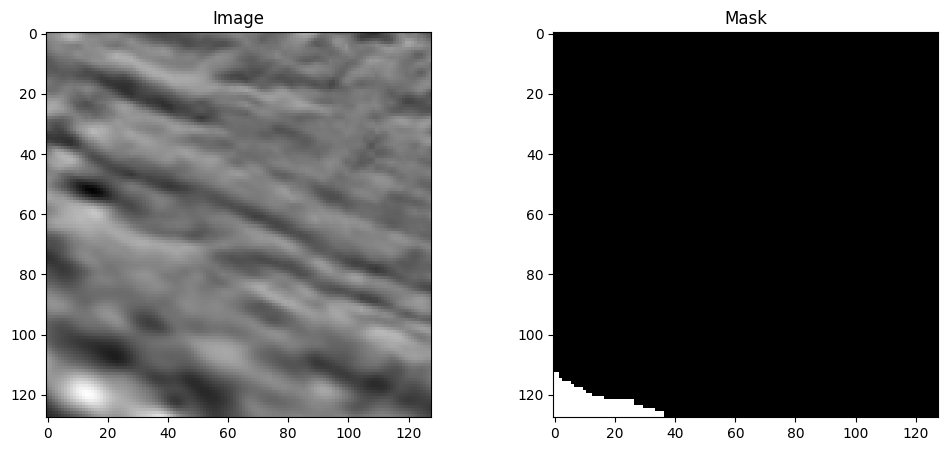

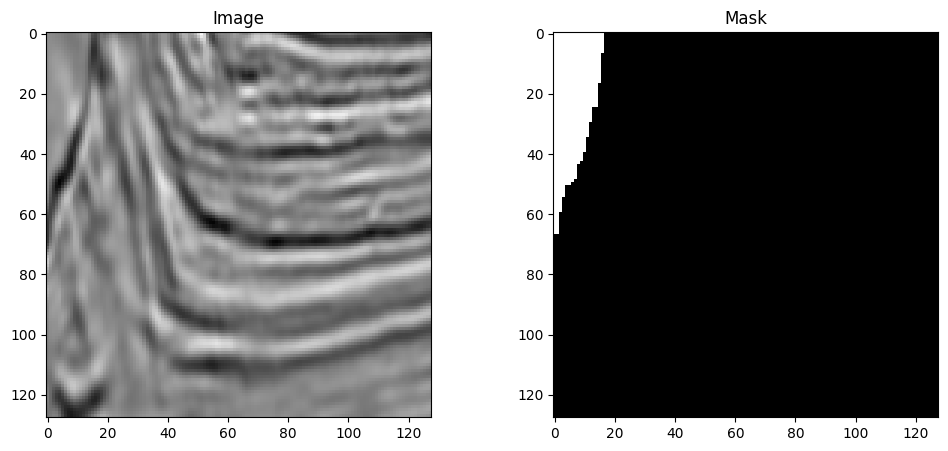

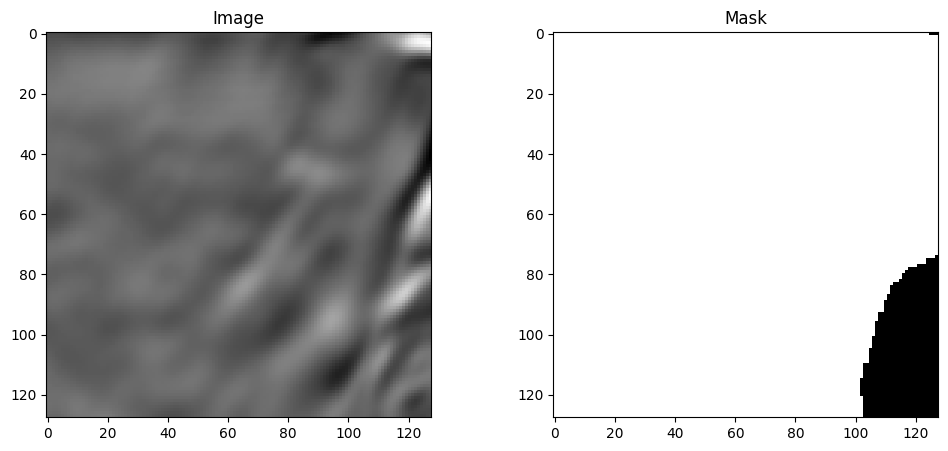

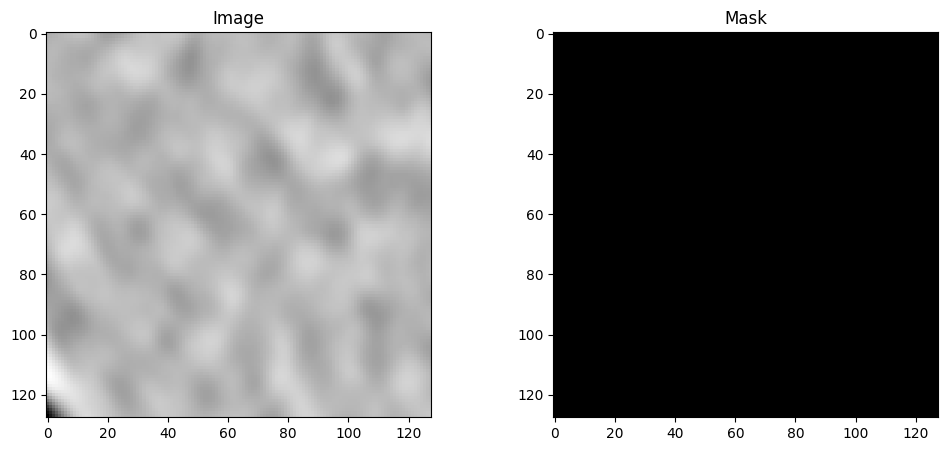

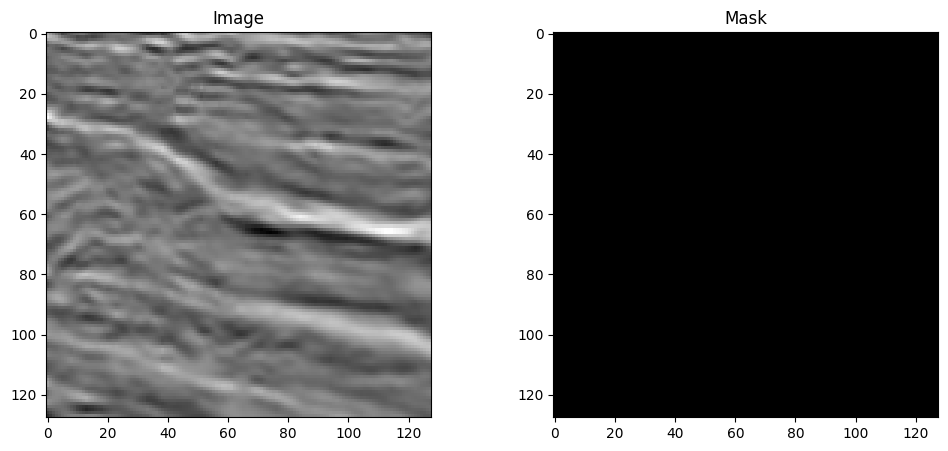

Images value range: 0.0 - 1.0
Masks value range: 0 - 1


In [ ]:
# Inspecting the data after preproccessing
def inspect_data(images, masks, num_samples=5):

    # Randomly pick samples
    idx = np.random.choice(len(images), num_samples, replace=False)

    for i in idx:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


        ax1.imshow(images[i])
        ax1.set_title('Image')


        ax2.imshow(masks[i], cmap='gray')
        ax2.set_title('Mask')

        plt.show()

    # Print min and max values
    print(f"Images value range: {np.min(images)} - {np.max(images)}")
    print(f"Masks value range: {np.min(masks)} - {np.max(masks)}")

inspect_data(X_train, y_train)


In [ ]:
from tensorflow.keras import backend as K

# Define IoU metric
def IoU(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'))
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'))

    iou = tp / (tp + fp + fn + K.epsilon())
    return iou



In [ ]:
from sklearn.model_selection import train_test_split

# Splitting our training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.3,
                                                  random_state = 42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2450, 128, 128, 3)
(2450, 128, 128)
(1050, 128, 128, 3)
(1050, 128, 128)


# Part 1: Implementing U-net

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems.

If you want to use the `plot_training_history` function in the `visualization.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*. **However, it is voluntary to estimate IoU**

See example below:

```python
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import F1_score,
from visualization import plot_training_history,
...
model.compile(optimizer='Something',
                  loss='Something else',
                  metrics=[FalseNegatives(),
                           FalsePositives(),
                           TrueNegatives(),
                           TruePositives(),
                           F1_score,
                           OtherMetricOfChoice])

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)
```

You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation. **This is mandatory to use when compiling the model**.


## Task 1.1 Model implementation

Implement the classical U-net structure that you have learned about in the lectures. Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. **Remember to compile with the F1-score metric**.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from tensorflow.keras.optimizers import Adam
from utilities import F1_score


from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Dropout

def unet_model(input_shape=(128, 128, 3), dropout_rate=0.5):
    inputs = Input(input_shape)


    # Contracting Path
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate/2)(p1)

    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(dropout_rate)(c4)


    # Expansive Path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(128, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


model = unet_model(input_shape=(128, 128, 3))



# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       FalseNegatives(),
                       FalsePositives(),
                       TrueNegatives(),
                       TruePositives(),
                       F1_score,
                       IoU])



## Task 1.2 Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`

Epoch 1/30
49/49 [==============================] - 36s 553ms/step - loss: 0.4953 - accuracy: 0.7667 - false_negatives_4: 4127843.0000 - false_positives_4: 1855225.0000 - true_negatives_4: 17438548.0000 - true_positives_4: 2268498.0000 - F1_score: 0.4050 - IoU: 0.2704 - val_loss: 10.9090 - val_accuracy: 0.2406 - val_false_negatives_4: 0.0000e+00 - val_false_positives_4: 8361253.0000 - val_true_negatives_4: 0.0000e+00 - val_true_positives_4: 2648795.0000 - val_F1_score: 0.3847 - val_IoU: 0.2406 - lr: 0.0010
Epoch 2/30
49/49 [==============================] - 26s 542ms/step - loss: 0.4182 - accuracy: 0.8195 - false_negatives_4: 3163091.0000 - false_positives_4: 1459959.0000 - true_negatives_4: 17845612.0000 - true_positives_4: 3221451.0000 - F1_score: 0.5772 - IoU: 0.4127 - val_loss: 0.7601 - val_accuracy: 0.5817 - val_false_negatives_4: 1850332.0000 - val_false_positives_4: 2754751.0000 - val_true_negatives_4: 5606502.0000 - val_true_positives_4: 798463.0000 - val_F1_score: 0.2549 - val

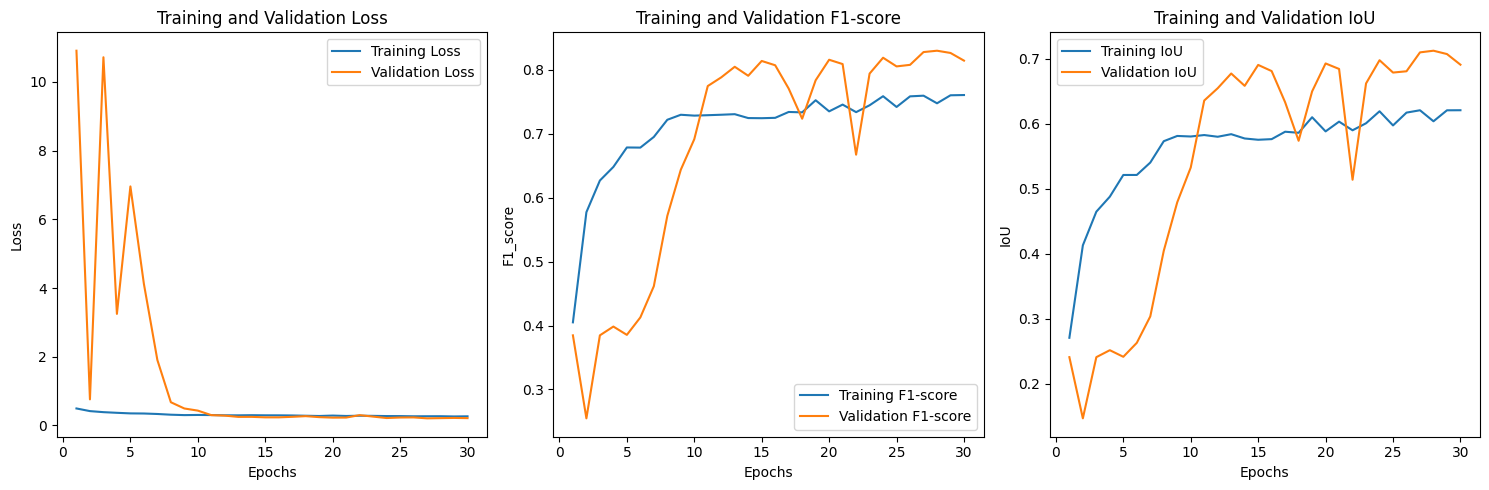

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define the augmentations for the images and masks
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

y_train = y_train[..., np.newaxis]

# Fit the data generator
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 1  # Seed defined to keep image and mask augmentation in sync
image_gen = image_datagen.flow(X_train, batch_size=32, seed=seed)
mask_gen = mask_datagen.flow(y_train, batch_size=32, seed=seed)

train_gen = zip(image_gen, mask_gen)



# Reduce lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


# Train the model
history= model.fit(train_gen,
                   steps_per_epoch=len(X_train)//32,
                   callbacks = [reduce_lr],
                   validation_data=(X_val, y_val),
                   epochs=30)




# Function for visualization
def visualize_history(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1_score= history.history['F1_score']
    val_f1_score = history.history['val_F1_score']

    iou = history.history['IoU']
    val_iou = history.history['val_IoU']

    epochs = range(1, len(loss) + 1)


    # Plotting loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, f1_score, label='Training F1-score')
    plt.plot(epochs, val_f1_score, label='Validation F1-score')
    plt.title('Training and Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1_score')
    plt.legend()

    # Plotting IoU
    plt.subplot(1, 3, 3)
    plt.plot(epochs, iou, label='Training IoU')
    plt.plot(epochs, val_iou, label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()



visualize_history(history)



## Task 1.3 Visualize model predictions

Make a plot that illustrates the original image, the predicted mask, and the ground truth mask.

1/1 [==============================] - 0s 21ms/step


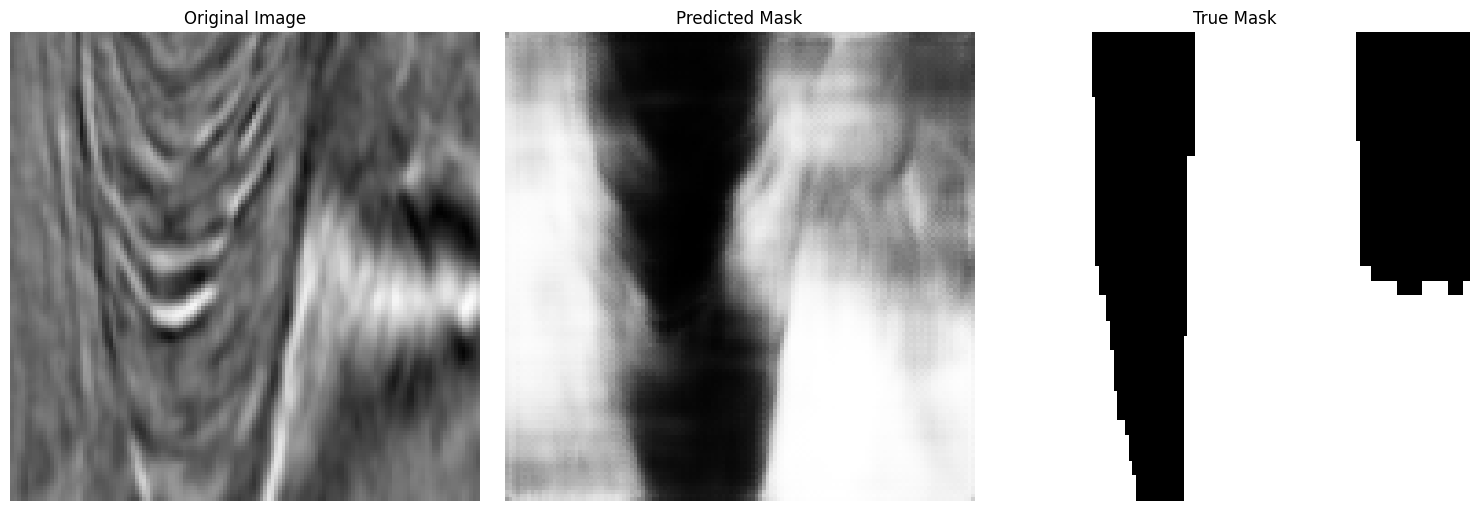

In [ ]:
# Select a random image from the training dataset
index = np.random.randint(0, len(X_train))


image = X_train[index]
ground_truth_mask = y_train[index]

# Predict the mask using the trained model
predicted_mask = model.predict(image[np.newaxis, ...])[0]

# Plot the original image, predicted mask, and the true mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask.squeeze(), cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(ground_truth_mask.squeeze(), cmap='gray')
axes[2].set_title('True Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()




# Part 2: Implementing U-net with transfer learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. There are many pre-trained back-bones to choose from. Pick freely from the selection here [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), or here [Keras model scores](https://keras.io/api/applications/) (nicer table in the second link). Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers. It might be expedient to only train them for 1-5 epochs on your PCs, and do the full training on Orion in Part 3.

## Task 2.1 Transfer learning model implementation

Implement a U-net model utilizing the pre-trained weights of a publically available network. **Remember to compile with the F1-score metric**.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Function for loading VGG16
def load_backbone(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    return base_model


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

###
# EXTENDED VGG16 BACKBONE FROM THE PREVIOUS
###

def extended_unet_with_vgg16_backbone(input_shape):

    base_model = load_backbone(input_shape)


    # Existing Contracting path
    c1 = base_model.get_layer('block1_conv2').output
    c2 = base_model.get_layer('block2_conv2').output
    c3 = base_model.get_layer('block3_conv3').output
    c4 = base_model.get_layer('block4_conv3').output


    # Existing Bottleneck
    c5 = base_model.get_layer('block5_conv3').output


    # Additional Contracting path
    c6 = layers.Conv2D(1024, (3, 3),  padding='same')(c5)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(1024, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    p6 = layers.MaxPooling2D((2, 2))(c6)


    # Additional Bottleneck
    c7 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p6)
    c7 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(c7)


    #  Expansive path
    u8 = layers.Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c6])
    c8 = layers.Conv2D(1024, (3, 3),  padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(1024, (3, 3), padding='same')(c8)
    c8=  layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    u9 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c4])
    c9 = layers.Conv2D(512, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(512, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    u10 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = layers.concatenate([u10, c3])
    c10 = layers.Conv2D(256, (3, 3), padding='same')(u10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Activation('relu')(c10)
    c10 = layers.Conv2D(256, (3, 3),  padding='same')(c10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Activation('relu')(c10)

    u11 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = layers.concatenate([u11, c2])
    c11 = layers.Conv2D(128, (3, 3), padding='same')(u11)
    c11 = layers.BatchNormalization()(c11)
    c11 = layers.Activation('relu')(c11)
    c11 = layers.Conv2D(128, (3, 3), padding='same')(c11)
    c11 = layers.BatchNormalization()(c11)
    c11 = layers.Activation('relu')(c11)

    u12 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = layers.concatenate([u12, c1])
    c12 = layers.Conv2D(64, (3, 3), padding='same')(u12)
    c12 = layers.BatchNormalization()(c12)
    c12 = layers.Activation('relu')(c12)
    c12 = layers.Conv2D(64, (3, 3), padding='same')(c12)
    c12 = layers.BatchNormalization()(c12)
    c12 = layers.Activation('relu')(c12)

    # Final Convolution
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c12)

    model = models.Model(inputs=[base_model.input], outputs=[outputs])

    return model


model = extended_unet_with_vgg16_backbone(input_shape=(128, 128, 3))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       FalseNegatives(),
                       FalsePositives(),
                       TrueNegatives(),
                       TruePositives(),
                       F1_score,
                       IoU])


## Task 2.2 Train the transfer learning model and plot the training history

Feel free to use the `plot_training_history` function from the provided library `utilities.py`

Epoch 1/30
76/76 [==============================] - 57s 577ms/step - loss: 0.3816 - accuracy: 0.8358 - false_negatives_2: 3546957.0000 - false_positives_2: 2950733.0000 - true_negatives_2: 26931986.0000 - true_positives_2: 6416213.0000 - F1_score: 0.6660 - IoU: 0.5121 - val_loss: 1.6054 - val_accuracy: 0.7951 - val_false_negatives_2: 2120426.0000 - val_false_positives_2: 1404955.0000 - val_true_negatives_2: 11333806.0000 - val_true_positives_2: 2344013.0000 - val_F1_score: 0.5646 - val_IoU: 0.3981 - lr: 0.0010
Epoch 2/30
76/76 [==============================] - 49s 611ms/step - loss: 0.2908 - accuracy: 0.8821 - false_negatives_2: 3203222.0000 - false_positives_2: 1415521.0000 - true_negatives_2: 28282160.0000 - true_positives_2: 6715606.0000 - F1_score: 0.7388 - IoU: 0.5919 - val_loss: 0.8268 - val_accuracy: 0.8549 - val_false_negatives_2: 805328.0000 - val_false_positives_2: 1690732.0000 - val_true_negatives_2: 11048029.0000 - val_true_positives_2: 3659111.0000 - val_F1_score: 0.7377 

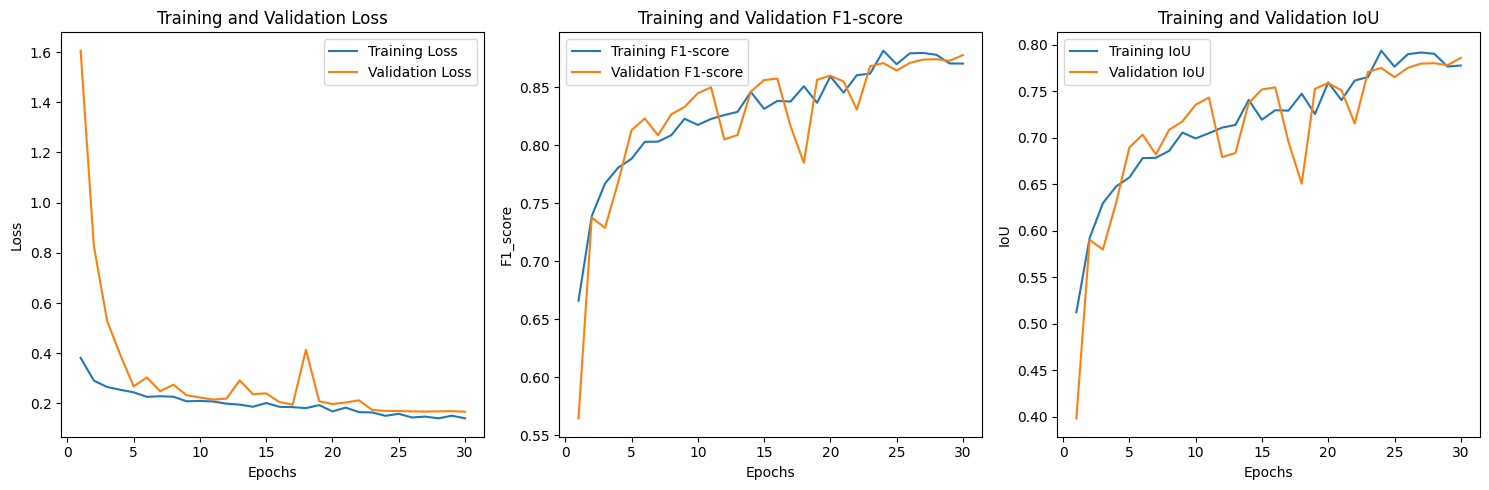

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


y_train = y_train.reshape((-1, 128, 128, 1))

# Define the augmentations for the images and masks
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


# Fit the data generator
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 1  # Seed defined to keep image and mask augmentation in sync
image_gen = image_datagen.flow(X_train, batch_size=32, seed=seed)
mask_gen = mask_datagen.flow(y_train, batch_size=32, seed=seed)

train_gen = zip(image_gen, mask_gen)



# Reduce lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


# Train the model
history= model.fit(train_gen,
                   steps_per_epoch=len(X_train)//32,
                   callbacks = [reduce_lr],
                   validation_data=(X_val, y_val),
                   epochs=30)



# Function for visualization
def visualize_history(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1_score= history.history['F1_score']
    val_f1_score = history.history['val_F1_score']

    iou = history.history['IoU']
    val_iou = history.history['val_IoU']

    epochs = range(1, len(loss) + 1)


    # Plotting loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, f1_score, label='Training F1-score')
    plt.plot(epochs, val_f1_score, label='Validation F1-score')
    plt.title('Training and Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1_score')
    plt.legend()

    # Plotting IoU
    plt.subplot(1, 3, 3)
    plt.plot(epochs, iou, label='Training IoU')
    plt.plot(epochs, val_iou, label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()



visualize_history(history)